In [4]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
import pandas as pd 
import numpy as np 

from xgboost import XGBClassifier,DMatrix,train
from xgboost.callback import EarlyStopping
from xgboost import cv

from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,recall_score,accuracy_score,precision_score,precision_recall_curve,roc_curve,precision_recall_fscore_support
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample

In [6]:
X_train=np.array(pd.read_csv('C:\workspace\Credit-Risk-Modeling\dataset\kaggle_pd_estimation\X_train.csv',index_col=0))
y_train=np.array(pd.read_csv('C:\workspace\Credit-Risk-Modeling\dataset\kaggle_pd_estimation\y_train.csv',index_col=0).astype(int)).reshape(-1)

X_test=np.array(pd.read_csv('C:\workspace\Credit-Risk-Modeling\dataset\kaggle_pd_estimation\X_test.csv',index_col=0))
y_test=np.array(pd.read_csv('C:\workspace\Credit-Risk-Modeling\dataset\kaggle_pd_estimation\y_test.csv',index_col=0).astype(int)).reshape(-1).astype(int)


In [7]:
train_np=np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)

In [8]:
param={'n_estimators':list(np.linspace(10,2000,20)),'max_depth':[3,5,8,12,15],'eta':list(np.linspace(0.05,0.2,10)),'objective':'binary:logistic','tree_method':'hist'}

In [9]:
def homeMade_f1(y_true,y_pred):
    y_true=pd.Series(y_true).astype(int)
    y_pred=pd.Series(y_pred).astype(int)
    f1_acc_score=f1_score(y_true,y_pred)
    return f1_acc_score

In [10]:
def make_balance(fit_df):
    fit_df_0=fit_df[fit_df[:,-1]==0]
    fit_df_1=fit_df[fit_df[:,-1]==1]
    max_count=np.floor(len(fit_df_0)/len(fit_df_1))
    residuals=int(len(fit_df_0)-max_count*len(fit_df_1))
    balance_count=1
    fit_df2=np.array(pd.DataFrame(fit_df_1).copy())
    while balance_count<max_count:
        fit_df2=np.concatenate((fit_df2,fit_df_1))
        balance_count=balance_count+1
    fit_df2=np.concatenate((fit_df2,resample(fit_df_1,replace=False,n_samples=residuals)))
    fit_df2=np.concatenate((fit_df2,fit_df_0))
    fit_df2=resample(fit_df2,replace=False,n_samples=len(fit_df2))
    return fit_df2

In [11]:
def ensemble_xgb(train_np,params,test_size=0.3):
    n_estimators=params['n_estimators']
    object=params['objective']
    tree_method=params['tree_method']
    depth_list=params['max_depth']
    eta_list=params['eta']
    model_dic={}
    model_number=1
    
    fit_df,val_df=train_test_split(train_np,random_state=None,test_size=test_size,stratify=train_np[:,-1])
    
    fit_df2=make_balance(fit_df) 
    X_fit=fit_df2[:,:-1]
    y_fit=fit_df2[:,-1]

    #val_df2=make_balance(val_df) 
    X_val=val_df[:,:-1]
    y_val=val_df[:,-1]

    for i in depth_list:
        for j in eta_list:
            for k in n_estimators:
                model=XGBClassifier(n_estimators=np.round(k),objective=object,tree_method=tree_method,early_stopping_rounds=50,
                                    learning_rate=j,max_depth=i,n_jobs=-1,eval_metric=['aucpr']).fit(X_fit,y_fit,eval_set=[(X_val,y_val)])
                #f_1_accuracy_score=f1_score(y_val,pred)
                model_dic['model_number_{}'.format(model_number)]=\
                    {'n_estimators':model.best_iteration,'max_depth':i,'learning_rate':j,'accuracy_score':model.best_score}
                print(model_dic['model_number_{}'.format(model_number)])
                model_number=model_number+1


    model_df=pd.DataFrame(model_dic)
    
    return model_df


In [15]:
param1={'n_estimators':[20000],'max_depth':[3,5,8,12,15],'eta':[0.1,0.05,0.01],'objective':'binary:logistic','tree_method':'hist'}
len(param1['n_estimators'])*len(param1['max_depth'])*len(param1['eta'])

15

In [16]:
selected_model1=ensemble_xgb(train_np,param1)

[0]	validation_0-aucpr:0.76032
[1]	validation_0-aucpr:0.75842
[2]	validation_0-aucpr:0.75842
[3]	validation_0-aucpr:0.76114
[4]	validation_0-aucpr:0.77058
[5]	validation_0-aucpr:0.77327
[6]	validation_0-aucpr:0.76773
[7]	validation_0-aucpr:0.76767
[8]	validation_0-aucpr:0.78050
[9]	validation_0-aucpr:0.79966
[10]	validation_0-aucpr:0.80307
[11]	validation_0-aucpr:0.80428
[12]	validation_0-aucpr:0.80792
[13]	validation_0-aucpr:0.80419
[14]	validation_0-aucpr:0.80892
[15]	validation_0-aucpr:0.81245
[16]	validation_0-aucpr:0.81700
[17]	validation_0-aucpr:0.81680
[18]	validation_0-aucpr:0.81918
[19]	validation_0-aucpr:0.82171
[20]	validation_0-aucpr:0.82090
[21]	validation_0-aucpr:0.82267
[22]	validation_0-aucpr:0.82394
[23]	validation_0-aucpr:0.82361
[24]	validation_0-aucpr:0.82514
[25]	validation_0-aucpr:0.82559
[26]	validation_0-aucpr:0.82848
[27]	validation_0-aucpr:0.82988
[28]	validation_0-aucpr:0.83093
[29]	validation_0-aucpr:0.83003
[30]	validation_0-aucpr:0.83110
[31]	validation_0-

In [29]:
selected_model1=selected_model1.transpose()#.sort_values(['accuracy_score','learning_rate','max_depth'],ascending=[False,False,True])

In [18]:
selected_model1.sort_values(['accuracy_score','learning_rate','max_depth'],ascending=[False,False,True])

,n_estimators,max_depth,learning_rate,accuracy_score
model_number_4,412.0,5.0,0.10,0.901130
model_number_8,367.0,8.0,0.05,0.900089
model_number_7,137.0,8.0,0.10,0.899621
model_number_5,568.0,5.0,0.05,0.899429
model_number_6,2474.0,5.0,0.01,0.897719
model_number_9,1281.0,8.0,0.01,0.897459
model_number_10,471.0,12.0,0.10,0.897183
model_number_13,340.0,15.0,0.10,0.896501
model_number_14,709.0,15.0,0.05,0.895973
model_number_11,349.0,12.0,0.05,0.895774


In [39]:
train_np2=make_balance(train_np) 
X_train=train_np2[:,:-1]
y_train=train_np2[:,-1]
model=XGBClassifier(n_estimators=412,max_depth=5,learning_rate=0.1,n_jobs=-1,objective='binary:logistic').fit(X_train,y_train)
pred=model.predict(X_test)
est_prob=model.predict_proba(X_test)

In [40]:
confusion_matrix(y_test,pred)

array([[4885,  210],
       [ 282, 1140]], dtype=int64)

In [41]:
recall_score(y_test,pred)

0.8016877637130801

In [42]:
precision_score(y_test,pred)

0.8444444444444444

In [43]:
f1_score(y_test,pred)

0.8225108225108224

In [44]:
accuracy_score(y_test,pred)

0.9245051404020255

In [45]:
accuracy_score(y_test,pred)

0.9245051404020255

In [46]:
roc_auc_score(y_test,pred)

0.8802354422098276

In [87]:
precision_recall_fscore_support(y_test,pred)

(array([0.94542288, 0.84444444]),
 array([0.95878312, 0.80168776]),
 array([0.95205613, 0.82251082]),
 array([5095, 1422], dtype=int64))

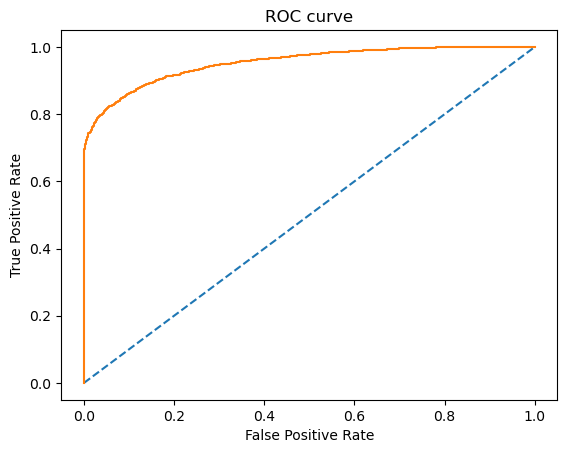

In [78]:
import matplotlib.pyplot as plt
fpr=roc_curve(y_test,est_prob[:,1])[0]
tpr=roc_curve(y_test,est_prob[:,1])[1]
#plt.figure(figsize=(20,8))
plt.plot(fpr,fpr,'--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

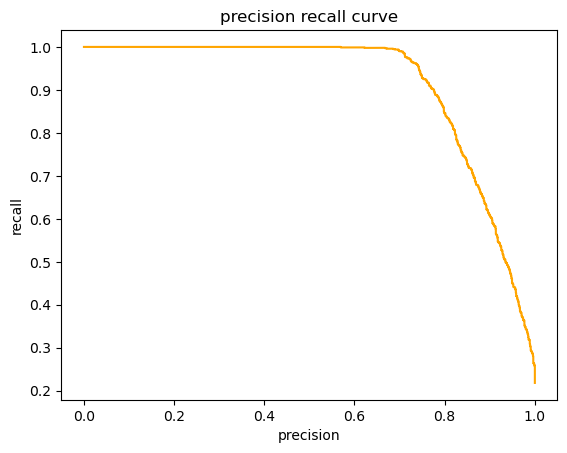

In [84]:
recall_axis=precision_recall_curve(y_test,est_prob[:,1])[0]
precision_axis=precision_recall_curve(y_test,est_prob[:,1])[1]
plt.plot(precision_axis,recall_axis,c='orange')
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('precision recall curve')
plt.show()